In [1]:
import pandas as pd
import numpy as np
import pystan
import pandas as pd
import numpy as np
import time
import diagnostics
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import seaborn as sns

import warnings; warnings.simplefilter('ignore')

In [2]:
path = '../big_data/sneaker_transactions.csv'

In [3]:
def MakeTimeSeriesData(path):
    data = pd.read_csv(path, index_col=0)
    data.createdAt = data.createdAt.str.replace('T', ' ')
    
    data.createdAt = data.createdAt.str.split(' ').str[0]
    data.createdAt = pd.to_datetime(data.createdAt)

    time_data = data.loc[:, ('sku', 'createdAt')]
    ordered_data = time_data.sort_values('createdAt')

    daily_count = ordered_data.groupby('createdAt').count()
    daily_count['date'] = daily_count.index
    daily_count = daily_count.reset_index().loc[:, ('sku', 'date')]
    daily_count.columns = ['volume', 'date']
    daily_count.date = pd.to_datetime(daily_count.date)
    
    return(daily_count)

In [4]:
daily_volume = MakeTimeSeriesData(path)

In [5]:
def EngineerFeatures(daily_volume, days_rolling, days_forward):
    over_threshold = daily_volume[daily_volume['volume'] > 50]
    
    over_threshold['day_of_week'] = over_threshold['date'].dt.day_name()
#     over_threshold['day_of_week'] = over_threshold['date'].dt.dayofweek
    over_threshold['month'] = over_threshold['date'].dt.month_name()
#     over_threshold['month'] = over_threshold['date'].dt.month
    over_threshold['year'] = over_threshold['date'].dt.year
    over_threshold['year'] = over_threshold['year'].astype('category')
    over_threshold['day_of_year'] = over_threshold['date'].dt.dayofyear
    over_threshold['rolling_mean_week'] = over_threshold['volume'].rolling(days_rolling).mean()
    over_threshold['rolling_median_week'] = over_threshold['volume'].rolling(days_rolling).median()
    over_threshold['rolling_sd_week'] = over_threshold['volume'].rolling(days_rolling).std()
    over_threshold['rolling_max_week'] = over_threshold['volume'].rolling(days_rolling).max()
    over_threshold['projected_volume'] = over_threshold.volume.shift(-days_forward)

    dr = pd.date_range(start='2017-02-16', end='2019-06-16')
    df = pd.DataFrame()
    df['Date'] = dr

    cal = calendar()
    holidays = cal.holidays(start=dr.min(), end=dr.max())
    holidays = list(holidays.strftime("%Y-%m-%d"))
    non_federal_holidays = ['2017-10-31', '2018-10-31', '2017-11-24', '2017-11-25', '2017-11-26', '2018-11-23', 
                            '2018-11-24', '2018-11-25', '2017-12-26', '2017-12-27', '2017-12-28', '2018-12-26',
                            '2018-12-27', '2017-12-28']
    
    holidates = holidays + non_federal_holidays 

    over_threshold['holiday'] = over_threshold['date'].isin(holidates).astype(int)

    sneaker_releases = pd.read_csv('sneaker_metadata.csv')

    release_dates = sneaker_releases.loc[:, ('brand', 'releaseDate')]

    release_dates.releaseDate = release_dates.releaseDate.str.split(' ').str[0]
    
    grouped_release = release_dates.groupby('releaseDate').count()
    grouped_release['date'] = grouped_release.index
    grouped_release.date = pd.to_datetime(grouped_release.date)
    grouped_release = grouped_release.reset_index(drop=True)
    grouped_release.columns = ['total_release', 'date']
    
    merged_release = pd.merge(over_threshold, grouped_release, how = 'left', on='date')
    merged_release.total_release = merged_release.total_release.fillna(0)
    
    merged_release['total_release'] = merged_release['total_release'].shift(-days_forward)
    merged_release['total_release'] = np.where(merged_release['total_release'] > 0, 1, 0)
    
    return merged_release

In [6]:
model_df = EngineerFeatures(daily_volume, 7, 7)
# model_df['rolling_releases'] = model_df.total_release.iloc[::-1].rolling(5, min_periods=0).sum().iloc[::-1]
# model_df['rolling_holiday'] = model_df.holiday.iloc[::-1].rolling(7, min_periods=0).sum().iloc[::-1]

In [7]:
def SplitTrainTest(model_df, train_pct):
    
    model_df = model_df[model_df['date'] > '2017-10-30']
    data = model_df.drop("date", axis=1)
    
    rf_df = pd.get_dummies(data)
    rf_df = rf_df.dropna()
    rf_df = rf_df.reset_index(drop = True)

    # Labels are the values we want to predict
    labels = np.array(rf_df['projected_volume'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features= rf_df.drop('projected_volume', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)
    
    split_axis = round(len(model_df) * train_pct)
    
    train = rf_df[:split_axis]
    test = rf_df[split_axis:-4]

    train_labels = np.array(train['projected_volume'])
    train_features = train.drop('projected_volume', axis = 1)

    test_labels = np.array(test['projected_volume'])
    test_features = test.drop('projected_volume', axis = 1)

    return train_features, train_labels, test_features, test_labels

In [8]:
train_features, train_labels, test_features, test_labels = SplitTrainTest(model_df, train_pct = 0.8)

In [9]:
lin_reg_normal = """
    /* Spec for robust linear regression model */
    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of features
        matrix[N, K] X;                     // feature matrix
        real y[N];          // target
    }
    parameters {
        real alpha;                         // constant
        vector[K] beta;                     // feature coefficients
        real<lower=0> sigma;
    }
    model { 
        alpha ~ normal(0,100);              // prior
        beta ~ normal(0,1);              // prior
        y ~ normal(alpha + X * beta, sigma);         // likelihood
    }
    generated quantities {}
    """

In [10]:
start = time.time()

stan_datadict = {}
stan_datadict['N'] = train_features.shape[0]
stan_datadict['K'] = train_features.shape[1]
stan_datadict['X'] = train_features.values
stan_datadict['y'] = train_labels

model = pystan.StanModel(model_code=lin_reg_normal)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7128a9b6e5211721054f8e0756b029ab NOW.


In [11]:
fit = model.sampling(data=stan_datadict,
                warmup=250,
                iter = 1000, 
                verbose = True)

In [12]:
end = time.time()
print(str(end-start))

51.93832612037659


In [13]:
print(diagnostics.check_treedepth(fit))
print(diagnostics.check_energy(fit))
print(diagnostics.check_div(fit))

0 of 3000 iterations saturated the maximum tree depth of 10 (0.0%)
None
E-BFMI indicated no pathological behavior
None
0.0 of 3000 iterations ended with a divergence (0.0%)
None


In [14]:
b = fit.extract(['alpha'])['alpha'].mean()
w = fit.extract(['beta'])['beta'].mean(axis=0)

In [15]:
b

39.207430366419146

In [16]:
w

array([ 0.38690792,  0.99217419,  1.28287831, -0.50979153, -1.03217035,
        0.00240007,  0.00500854,  0.04634882,  0.03317799, -0.02745576,
       -0.00274209, -0.01810516,  0.02851252,  0.01173238,  0.02579474,
        0.00632087,  0.0151039 , -0.05200126,  0.01737852, -0.00278328,
       -0.00130779,  0.00876369,  0.01227122, -0.00733496,  0.01663539,
       -0.01629986,  0.01470713,  0.00443316,  0.04729706,  0.04198458])

In [17]:
train_features.columns

Index(['volume', 'day_of_year', 'rolling_mean_week', 'rolling_median_week',
       'rolling_sd_week', 'rolling_max_week', 'holiday', 'total_release',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'month_April', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'year_2017', 'year_2018',
       'year_2019'],
      dtype='object')

In [18]:
predictions = test_features@w + b

[Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted')]

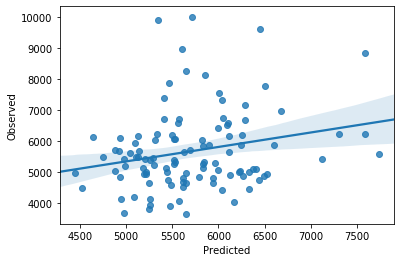

In [19]:
fig = sns.regplot(x=predictions, y=test_labels)
fig.set(xlabel='Predicted', ylabel='Observed')

In [20]:
tmp = fig.get_figure()
tmp.savefig('./test.png', dpi=400) 

In [21]:
print('Mean Absolute Percentage Error - Baseline:', round(np.mean(np.abs((test_labels - test_features.volume) / test_labels)) * 100))
print('Mean Absolute Percentage Error - Bayes:', round(np.mean(np.abs((test_labels - predictions) / test_labels)) * 100))


Mean Absolute Percentage Error - Baseline: 18.0
Mean Absolute Percentage Error - Bayes: 17.0


In [22]:
samples = fit.extract()

In [23]:
beta = samples['beta']

In [24]:
col_names = test_features.columns
weights = pd.DataFrame(beta)
weights.columns = col_names
melted_weights = weights.melt()

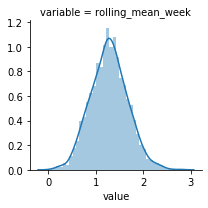

In [25]:
desired_features = ['rolling_mean_week']
posterior_features = melted_weights[melted_weights['variable'].isin(desired_features)]
g = sns.FacetGrid(posterior_features, col='variable', sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.savefig('./figures/variable_posteriors.png', dpi = 400)

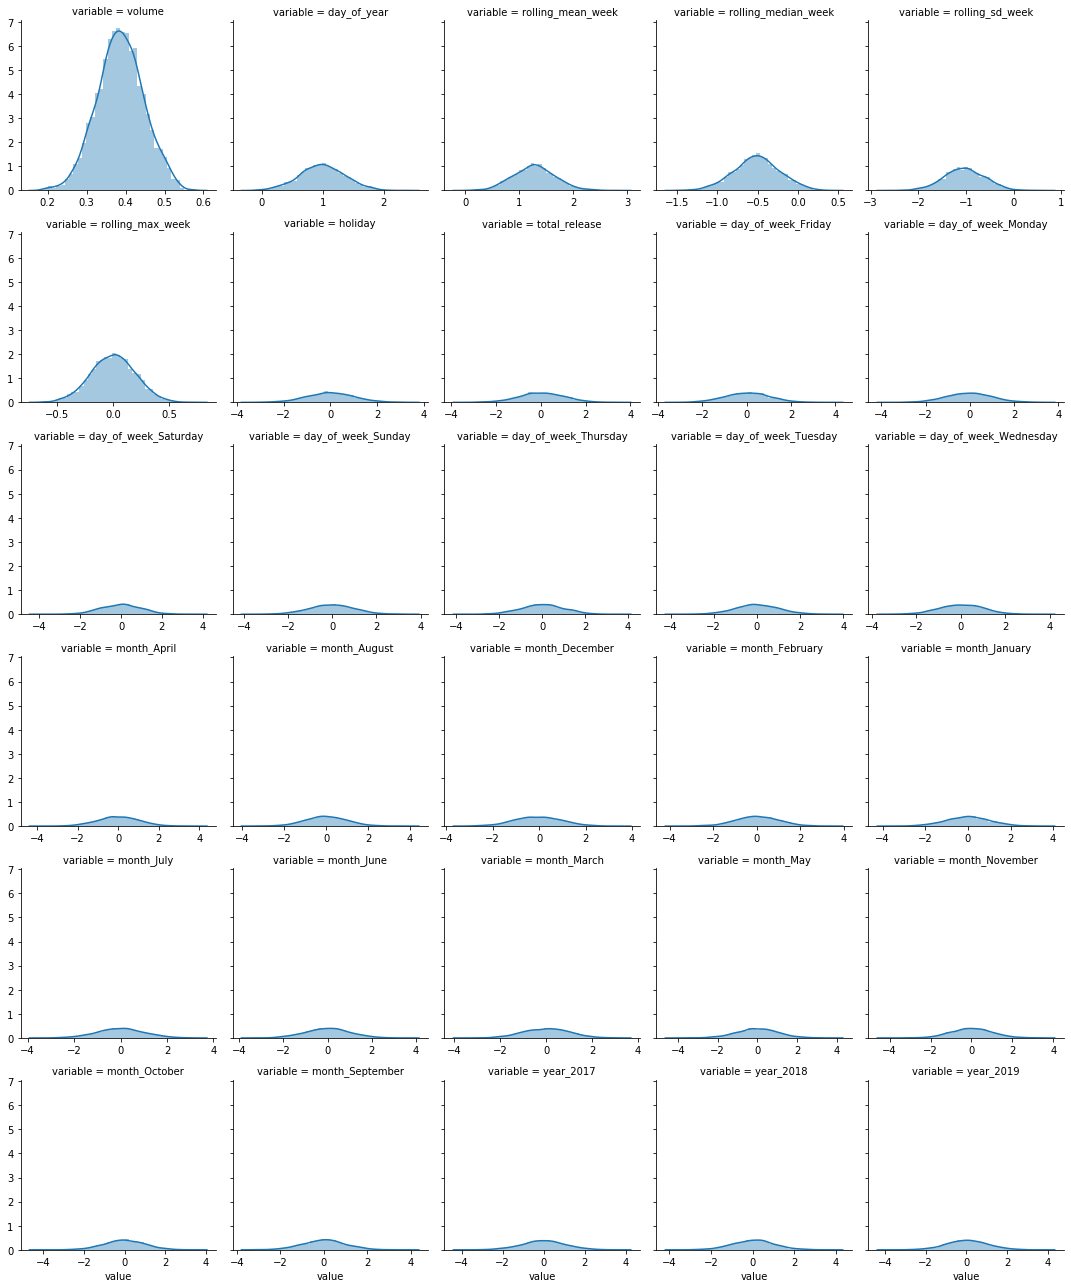

In [26]:
a = sns.FacetGrid(melted_weights, col='variable', col_wrap=5, sharex=False)
a = a.map(sns.distplot, "value")

In [27]:
one_example = test_features.head(1)

In [28]:
t_beta = beta.transpose()

In [29]:
prediction_interval = (one_example@t_beta).values
prediction_interval

array([[7365.57457879, 6884.22203711, 7352.21638516, ..., 7444.15284346,
        7202.99330573, 7502.70640599]])

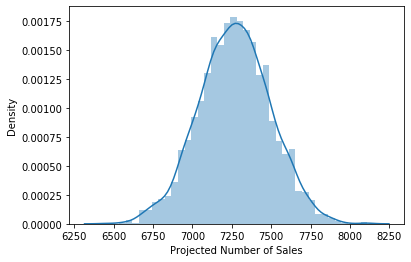

In [30]:
p = sns.distplot(prediction_interval)
p.set(xlabel='Projected Number of Sales', ylabel='Density')
p.figure.savefig('./figures/posterior_predictions.png', dpi = 400)

In [31]:
prediction_interval = (one_example@t_beta).values

In [32]:
from itertools import chain

In [33]:
tmp = list(chain.from_iterable(prediction_interval))

https://github.com/aloctavodia/BAP

In [34]:
from __future__ import division
import numpy as np
import scipy.stats.kde as kde

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = kde.gaussian_kde(sample)
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    modes = []
    for value in hpd:
         x_hpd = x[(x > value[0]) & (x < value[1])]
         y_hpd = y[(x > value[0]) & (x < value[1])]
         modes.append(round(x_hpd[np.argmax(y_hpd)], roundto))
    return hpd, x, y, modes

In [35]:
intervals, x, y, modes = hpd_grid(tmp, alpha=0.05)

In [36]:
intervals[0]

(6820.23, 7734.26)